epoch:  9900
loss:  tensor(0.7412, device='cuda:0', grad_fn=<AddBackward0>)
accuracy on X:  tensor(0.8900, device='cuda:0')


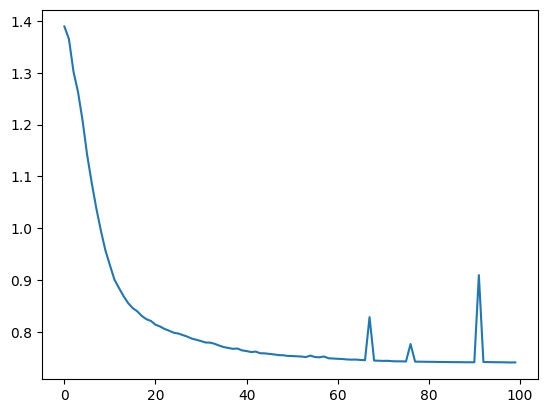

average success rate of class 0:  tensor(0.5271, device='cuda:0')
average success rate of class 1:  tensor(0.6487, device='cuda:0')


In [9]:
#Implements Scheffes test by first building a classifier between X and Y, then classifies Y.
from sklearn.utils import check_random_state
import numpy as np
import torch
import sys
from matplotlib import pyplot as plt
from tqdm import trange
import pickle
from LFI import *
from Data_gen import *
from IPython.display import clear_output
import os 

class Classifier(torch.nn.Module):
    """Latent space for both domains."""
    """ Dense Net with w=50, d=4, ~relu, in=2, out=50 """
    def __init__(self, x_in, H):
        """Init latent features."""
        super(Classifier, self).__init__()
        self.latent = torch.nn.Sequential(
            torch.nn.Linear(x_in, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, 2, bias=True),
            torch.nn.Softmax()
        )
    def forward(self, input):
        """Forward the LeNet."""
        fealant = self.latent(input)
        return fealant



def train(model, X, Y, criterion, batch_size=64, lr=0.0002, epochs=10000):
    """Label the items first
        items in X have label 0, items in Y have label 1
        then train the model with sgd
        X, Y are numpy arrays
        X has shape (N1, 2), Y has shape (N2, 2)
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_records = []
    for epoch in range(epochs):
        for i in range(0, len(X), batch_size):
            optimizer.zero_grad()
            X_batch = X[i:i+batch_size]
            Y_batch = Y[i:i+batch_size]
            X_batch = torch.from_numpy(X_batch).float()
            Y_batch = torch.from_numpy(Y_batch).float()
            output_X = model(X_batch.to(device)).to(device)
            output_Y = model(Y_batch.to(device)).to(device)
            loss_X = criterion(output_X, torch.zeros(len(X_batch)).long().to(device))
            loss_Y = criterion(output_Y, torch.ones(len(Y_batch)).long().to(device))
            loss = loss_X + loss_Y
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            clear_output(True)
            loss_records.append(loss.detach().cpu().numpy())
            print("epoch: ", epoch)
            print("loss: ", loss)
            print("accuracy on X: ", inference(model, len(X), X))
            
    plt.plot(range(len(loss_records)),loss_records)
    plt.show()
    #raise Exception("Done training")
    return model
    

def inference(model,size_m, Z, target_label=0):
    '''Inference on Z
        make sure no gradient is computed
        z is m pieces of data
        Z = Z.to(device)
        class=torch.sum(argmax(model(Z)))
    compute probability of data in z be 0
    '''
    with torch.no_grad():
        success = 0
        if True:
            Z = torch.from_numpy(Z).float()
            class_ = torch.argmax(model(Z.to(device)), dim=1)
            success += torch.sum(class_ == target_label)
        return success/size_m

if __name__ == "__main__":
    try:
        title=sys.argv[1]
    except:
        title='untitled_run'
    ##### Data #####
    sigma_mx_2_standard = np.array([[0.03, 0], [0, 0.03]])
    sigma_mx_2 = np.zeros([9,2,2])
    for i in range(9):
        sigma_mx_2[i] = sigma_mx_2_standard
        if i < 4:
            sigma_mx_2[i][0 ,1] = -0.02 - 0.002 * i
            sigma_mx_2[i][1, 0] = -0.02 - 0.002 * i
        if i==4:
            sigma_mx_2[i][0, 1] = 0.00
            sigma_mx_2[i][1, 0] = 0.00
        if i>4:
            sigma_mx_2[i][1, 0] = 0.02 + 0.002 * (i-5)
            sigma_mx_2[i][0, 1] = 0.02 + 0.002 * (i-5)
    device = torch.device("cuda")
    n=100
    m=50
    ##### Train #####
    x_in=2
    H=50
    model=Classifier(x_in, H).to(device)
    criterion = torch.nn.CrossEntropyLoss().cuda()
    X, Y=sample_blobs_Q(n, sigma_mx_2)
    model=train(model, X, Y, criterion)
    
    ##### Test #####
    total=0
    for trial in range(1000):
        Z, _ = sample_blobs_Q(m, sigma_mx_2)
        success = inference(model, m, Z, target_label=0)
        total += success
    print("average success rate of class 0: ", total/1000)
    total=0
    for trial in range(1000):
        _, Z = sample_blobs_Q(m, sigma_mx_2)
        success = inference(model, m, Z, target_label=1)
        total += success
    print("average success rate of class 1: ", total/1000)
    